(3059, 2)
3059
(4662, 3059)
4662
0.08533279044760879


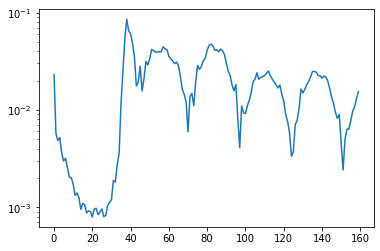

In [3]:
import ezyrb
from ezyrb import POD, GPR, RBF, Database
from ezyrb import ReducedOrderModel as ROM
import numpy as np

pod=POD('svd')
# RBF: input (parame,snapshot) 
# we choose the RBF interpolation among the parameters
rbf = RBF(kernel='multiquadric', smooth=0.65) #smooth is ur r.
#rbf = RBF(kernel='gaussian', smooth=0.65) #smooth is ur r.
# we build a database
mu2=np.linspace(0.01,1, 19)
num_sample =19
#pc 
mu2=mu2[0:num_sample]
num_time=161
time= np.linspace(0,num_time,num_time)

params= np.zeros((len(time),2) )
params[:,0]= np.ones((len(time), 1)).reshape(-1,)
params[:,0]*=np.round(mu2[0],4)
params[:,1] = time
for i in range(1, len(mu2)):
    tmp_ = np.zeros((len(time),2))
    tmp_[:,0]= np.ones((len(time), 1)).reshape(-1,)
    tmp_[:,0]*=np.round(mu2[i],4) # tmp_[:,0]= tmp_[:,0]*mu2[i]    
    tmp_[:,1] = time
    params = np.vstack((params,tmp_))
    
#print(params)
print(params.shape)
snapshots = np.loadtxt('SnapshotMatrix.csv',delimiter=",")
print(len(params))
print(snapshots.shape)
print(len(snapshots))
db = Database(params, snapshots.T)
# we construct the class and fit 
pod = POD('svd') # rank=0.9999
computedPOD = True #False
computeRBF= True 
if computedPOD:
    _=pod.reduce(snapshots)
    #num_modes=pod._modes.shape[1] #numpy array shape => return tuple of 2 element, array.shape[1] num  of columns
    s = pod._singular_values
    cumulative_energy = np.cumsum(s**2 / (s**2).sum())
    rank=np.where(cumulative_energy<0.9999999)[0]
    for i in  rank:
        np.savetxt("POD_{}.csv".format(i),pod._modes[:,i])
    #print(pod._singular_values)
    np.savetxt("sigmas_.csv",pod._singular_values)
    np.savetxt("sigmas_selected.csv",pod._singular_values[rank])
    pod._modes= pod._modes[:,rank]
    
else:
    pod._singular_values=np.loadtxt("sigmas_selected.csv")
    modes=np.zeros((snapshot.shape[0],len(pod._singular_values)))
    for i in range(0,len(pod._singular_values)):
        modes[:,i]=np.loadtxt("POD_{}.csv".format(i))
    pod._modes = modes

reducedcoord = pod._modes.T.dot(db.snapshots.T).T # Projection of snapshot on POD basis.
# number of snap x number of basis
rbf.fit(db.parameters,reducedcoord)

##ONLINE
# Save RBF function..    
#.....
fem_full= np.loadtxt('U1_2.csv',delimiter=",") #mu2[1], timeserie (true) 

error_pod_vs_fea= np.zeros((len(time)-1,1))
for item,t in enumerate(time):
    
    new_mu = [np.round(mu2[1],4), t]
    rbf_prediction = np.atleast_2d(rbf.predict(new_mu)).T
    pod_solutionOnline=pod.expand(rbf_prediction) #prediciton with ROM-RBF
    true_solution= fem_full[:,item] #abaqus sol
    if item>0:
        error= np.linalg.norm(pod_solutionOnline-true_solution)/np.linalg.norm(true_solution)
        error_pod_vs_fea[item-1]=error
        #print("error relative l2, {} at time {} with param {}".format(error,t,new_mu[0]))    
import matplotlib
import matplotlib.pyplot as plt

# Data for plotting
fig, ax = plt.subplots()
ax.semilogy(error_pod_vs_fea)
#fig.savefig("error_in_time.png")
print(error_pod_vs_fea.max())

In [4]:
pod.modes.T.shape

(71, 4662)

In [5]:
snapshots.shape


(4662, 3059)

In [6]:
pod._modes.T.dot(db.snapshots.T).T.shape

(3059, 71)

In [7]:
np.atleast_2d(rbf.predict(new_mu)).T.shape

(71, 1)